# Import Packages and Data

In [37]:
# import necessary libraries
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from sklearn.model_selection import GridSearchCV
from pyspark.sql.functions import explode
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [7]:
# instantiate SparkSession object
spark = SparkSession\
        .builder\
        .appName("ALSExample").config("spark.driver.host","localhost")\
        .getOrCreate()

In [8]:
# read in the dataset into pyspark DataFrame
movie_ratings = spark.read.csv('../data/test_data/ratings.csv', header='true', inferSchema = 'true')


In [9]:
movie_ratings = movie_ratings.drop('timestamp')


# Grid Search Optimal Hyperparameters with Cross Validation

In [10]:
als_model =  ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
               
params = ParamGridBuilder().addGrid(als_model.regParam, [0.15]).addGrid(als_model.rank, [42]).build()
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

In [11]:
## instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)
best_model = cv.fit(movie_ratings)    

In [12]:
predictions = best_model.transform(movie_ratings)
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.6320086196369294


In [13]:
rank = best_model.bestModel.rank
rank

42

In [14]:
best_model.getEstimatorParamMaps()

[{Param(parent='ALS_c6848777955f', name='regParam', doc='regularization parameter (>= 0).'): 0.15,
  Param(parent='ALS_c6848777955f', name='rank', doc='rank of the factorization'): 42}]

In [15]:
best_model.avgMetrics

[0.8851824225214353]

# Run Model with full data using parameters from grid search

In [16]:
user_factors = best_model.bestModel.userFactors
recommendationsDF = (user_factors
  .select("id", explode("features")
  .alias("features"))
  .select('id',"features")
)

In [17]:
rec_pdf = recommendationsDF.toPandas()
rec_pdf.head()

,id,features
0,10,0.244014
1,10,0.338341
2,10,0.429974
3,10,-0.139013
4,10,-0.633768


In [18]:
multiplier = rec_pdf['id'].nunique()
feature_array = np.array(list(range(1,rank+1))*multiplier)
rec_pdf['value'] = feature_array

In [19]:
rec_pdf_unstacked = rec_pdf.pivot(index='id', columns='value', values='features')

In [20]:
rec_pdf_unstacked.head()

value,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
id,,,,,,,,,,,,,,,,,,,,,
1,-0.225631,0.462445,0.244483,0.384418,-0.588707,0.111337,-0.232193,0.379394,-0.420569,0.376861,...,-0.448069,-0.122033,0.086638,-0.233508,-0.258614,-0.357465,0.025196,-0.388289,-0.525960,0.825885
2,-0.554159,0.213009,0.091612,0.225468,-0.434699,0.078257,-0.003110,0.245150,-0.398504,0.419588,...,-0.458860,-0.017984,-0.113895,0.147946,-0.386267,-0.253858,0.065193,-0.415113,-0.489709,0.535756
3,-0.550588,0.514188,-0.220600,0.006631,0.346615,0.194606,-0.051847,0.259825,0.195242,0.703040,...,-0.018918,0.269123,0.085465,0.093329,-0.287493,0.336695,-0.026440,0.067900,0.503551,0.466589
4,-0.139539,0.171325,-0.139473,0.121135,-0.862326,-0.069822,0.230150,0.519130,-0.235499,0.067366,...,-0.278693,0.175860,0.404359,-0.228848,0.040090,-0.289818,0.390717,-0.440118,-0.357919,0.634323
5,-0.282128,0.201916,0.229932,0.357938,-0.620102,-0.083303,-0.081967,0.147528,-0.412045,0.078472,...,-0.132362,-0.074574,0.166623,-0.236418,-0.051419,-0.474656,0.150248,-0.403191,-0.367464,0.776689


# Hierarchical Agglomerative Cluster Analysis

In [21]:
scaler = StandardScaler()
rec_pdf_scaled = scaler.fit_transform(rec_pdf_unstacked)

/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


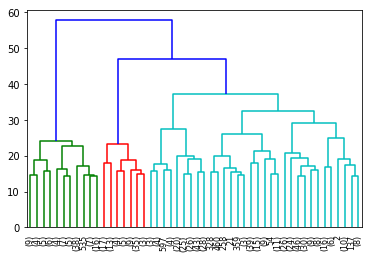

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
%matplotlib inline

z = linkage(rec_pdf_scaled, 'ward', metric = 'euclidean') # Ward linkage used to produce tightly knit clusters
c, coph_dist = cophenet(z, pdist(rec_pdf_scaled))
dendrogram(z,
          leaf_rotation=90,
          leaf_font_size = 8.,
          truncate_mode='lastp',
          p=50)
plt.show()

In [23]:
# coph_dist.sort()
# set(coph_dist)

In [24]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
rec_pdf_clustered = pd.DataFrame(rec_pdf_scaled.copy())
cluster = AgglomerativeClustering(n_clusters=9, 
                                 affinity='euclidean',
                                 linkage='ward')
rec_pdf_clustered['cluster'] = cluster.fit_predict(rec_pdf_clustered)

In [25]:
rec_pdf_clustered.groupby(['cluster']).agg(['mean', 'std', 'count'])

0                         1                         2   \
             mean       std count      mean       std count      mean   
cluster                                                                 
0        0.678533  0.973334   102 -0.182310  0.965189   102  0.771391   
1       -0.378230  0.912340    75  0.020675  1.072841    75 -0.214250   
2       -0.606212  1.002973    86 -0.180809  0.921225    86 -0.833119   
3       -0.251855  1.886497     8 -2.044336  1.735499     8  0.212743   
4       -0.192859  0.692659   142  0.356676  0.897501   142  0.179291   
5        0.176282  0.699820   143 -0.232379  0.748251   143 -0.117578   
6        0.095128  1.284007    12  1.143967  0.875248    12 -0.059000   
7        0.106911  1.322703    20  0.473188  1.243007    20 -0.503315   
8        0.554715  1.497574    22  0.379094  0.922101    22  0.430080   

                               3   ...    38        39                  \
              std count      mean  ... count      mean       std count   
cluster                            ...                                   
0        1.008826   102 -0.852345  ...   102 -0.884309  0.733259   102   
1        0.840022    75  0.098960  ...    75  0.361537  0.846311    75   
2        0.994710    86  1.011638  ...    86  0.603213  1.038705    86   
3        1.195875     8  0.665928  ...     8 -0.291830  2.024785     8   
4        0.685943   142 -0.213840  ...   142  0.083504  0.662410   142   
5        0.826928   143  0.317102  ...   143 -0.030164  0.743885   143   
6        0.822685    12 -0.296915  ...    12  1.886715  1.209819    12   
7        1.177929    20 -0.370869  ...    20  0.227681  1.045690    20   
8        1.062710    22 -0.764141  ...    22 -0.963441  0.929154    22   

               40                        41                  
             mean       std count      mean       std count  
cluster                                                      
0        0.135654  0.831044   102  0.391714  1.161711   102  
1       -0.358411  0.916200    75 -0.086113  0.954587    75  
2       -0.261284  0.956281    86 -0.191337  0.942444    86  
3       -1.186200  1.911108     8 -0.049219  1.603565     8  
4       -0.137349  0.713828   142 -0.223174  0.770884   142  
5       -0.046868  0.764037   143  0.206326  0.792331   143  
6        0.723857  1.507980    12 -1.448602  1.726856    12  
7        1.596983  1.457763    20  0.089758  0.887584    20  
8        1.390174  1.052404    22  0.051205  1.274698    22  

[9 rows x 126 columns]

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(111, projection='3d')
# plt.scatter(rec_pdf_clustered[1], rec_pdf_clustered[5], rec_pdf_clustered[3], c=rec_pdf_clustered.cluster)
# plt.show();

# Cluster Centroids and Distances

In [26]:
cluster_centroids = rec_pdf_clustered.groupby(['cluster']).agg('mean')

In [27]:
cluster_centroids_array = cluster_centroids.to_numpy()

In [28]:
cluster_distance_matrix = distance_matrix(cluster_centroids_array, cluster_centroids_array, p=2)

In [29]:
cluster_distance_df = pd.DataFrame(cluster_distance_matrix)
cluster_distance_df

,0,1,2,3,4,5,6,7,8
0,0.000000,5.333267,7.412127,8.296717,3.373134,4.573202,7.192046,5.666988,4.574201
1,5.333267,0.000000,3.856667,6.877097,3.019124,2.898582,7.527609,4.665154,5.785893
2,7.412127,3.856667,0.000000,7.240603,5.144719,3.207948,7.885692,5.882565,6.618755
3,8.296717,6.877097,7.240603,0.000000,7.498372,7.100306,9.930179,9.356401,9.622295
4,3.373134,3.019124,5.144719,7.498372,0.000000,3.038676,5.816284,4.389755,4.623226
5,4.573202,2.898582,3.207948,7.100306,3.038676,0.000000,6.951569,4.801015,4.255280
6,7.192046,7.527609,7.885692,9.930179,5.816284,6.951569,0.000000,7.584318,6.830923
7,5.666988,4.665154,5.882565,9.356401,4.389755,4.801015,7.584318,0.000000,5.459062
8,4.574201,5.785893,6.618755,9.622295,4.623226,4.255280,6.830923,5.459062,0.000000


In [30]:
def nearest_clusters(cluster, num_nearest_clusters=2):
    sorted_distances = cluster_distance_df[cluster].sort_values(ascending=True)
    return sorted_distances[1:num_nearest_clusters+1].index.values.astype(int)

In [31]:
nearest_clusters(0, 2)

array([4, 5])

# Bootstrap Sample

In [32]:
bs_sample = rec_pdf_clustered.sample(n=5000, replace=True, axis=0, random_state=42)

# KNN Model (for assigning new user to a cluster)

In [33]:
bs_sample.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,cluster
102,-0.782939,0.365766,-0.974612,0.663531,-0.455871,-0.973882,-0.308984,0.456755,-0.345174,0.009831,...,-0.863321,-0.603966,0.687996,-0.634509,-0.071162,0.484988,0.466084,-1.372895,0.757928,1
435,0.641632,-0.415294,0.891829,0.059460,-0.064829,0.009458,0.041828,0.483449,0.383006,-1.856536,...,0.789455,0.606651,-0.425987,1.013339,-0.170240,-0.417268,-0.567872,0.138924,1.256035,0
270,-0.023143,-0.486587,-0.771678,-0.093755,0.467610,0.998220,-0.619329,0.243314,0.983117,-0.692106,...,-0.514183,1.313285,1.259937,0.703491,0.708715,-0.073146,1.023337,0.609747,0.999134,5
106,0.328351,-0.656945,1.661276,-0.883631,0.060652,0.361518,-0.502879,0.949366,0.352437,-1.499063,...,0.179452,0.984580,0.294296,-0.517440,-0.625789,-1.083569,-1.322961,-0.425741,1.775461,0
71,0.203523,0.216612,0.048158,-0.358833,-0.726166,-0.145945,-0.524061,-0.210638,-0.510078,0.587523,...,-0.842972,0.104039,-0.109596,-0.480622,0.123564,0.104575,0.138829,-0.728722,0.236056,1


In [34]:
X = bs_sample.iloc[:,:-1]
y = bs_sample.iloc[:,-1]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

In [ ]:
from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)
train_preds = knn.predict(X_train)
test_preds = knn.predict(X_test)
accuracy_score(y_test, test_preds), accuracy_score(y_train, train_preds)

In [ ]:
print(confusion_matrix(y_test, test_preds))
print(confusion_matrix(y_train, train_preds))

# Nearest Centroid

In [ ]:
from sklearn.neighbors import NearestCentroid
nc = NearestCentroid()
nc.fit(X_train, y_train)
nc_train_preds = nc.predict(X_train)
nc_test_preds = nc.predict(X_test)
accuracy_score(y_test, nc_test_preds), accuracy_score(y_train, nc_train_preds)

In [ ]:
print(confusion_matrix(y_test, nc_test_preds))
print(confusion_matrix(y_train, nc_train_preds))

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
dc = DecisionTreeClassifier(max_depth=8, max_features=8, criterion='gini', min_samples_leaf=9)
dc.fit(X_train, y_train)
dc_train_preds = dc.predict(X_train)
dc_test_preds = dc.predict(X_test)
accuracy_score(y_test, dc_test_preds), accuracy_score(y_train, dc_train_preds)

In [ ]:
print(confusion_matrix(y_test, dc_test_preds))
print(confusion_matrix(y_train, dc_train_preds))

# Random Forest

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
param_grid = {'criterion':['gini', 'entropy'], 
             'max_depth': [15],
             'min_samples_split': [5],
             'n_estimators': [50],
             'max_features': [6]}
gs_forest = GridSearchCV(rf, param_grid, cv=5)
gs_forest.fit(X_train, y_train)
gs_forest.best_params_

In [ ]:
gs_forest_train_preds = gs_forest.predict(X_train)
gs_forest_test_preds = gs_forest.predict(X_test)
accuracy_score(y_test, gs_forest_test_preds), accuracy_score(y_train, gs_forest_train_preds)

In [ ]:
print(confusion_matrix(y_test, gs_forest_test_preds))
print(confusion_matrix(y_train, gs_forest_train_preds))

# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier(learning_rate=.4)
ab.fit(X_train, y_train)
ab_train_preds = ab.predict(X_train)
ab_test_preds = ab.predict(X_test)
accuracy_score(y_test, ab_test_preds), accuracy_score(y_train, ab_train_preds)

In [ ]:
print(confusion_matrix(y_test, ab_test_preds))
print(confusion_matrix(y_train, ab_train_preds))

# Gradient Boosting Classifier

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
param_grid = {'learning_rate':[.15], 
             'max_depth': [5],
             'min_samples_split': [25],
             'n_estimators': [41],
             'max_features': [7]}
gs_gbc = GridSearchCV(gbc, param_grid, cv=5)
gs_gbc.fit(X_train, y_train)
gbc_train_preds = gs_gbc.predict(X_train)
gbc_test_preds = gs_gbc.predict(X_test)
accuracy_score(y_test, gbc_test_preds), accuracy_score(y_train, gbc_train_preds)

(1.0, 1.0)

In [39]:
gs_gbc.best_params_

{'learning_rate': 0.15,
 'max_depth': 5,
 'max_features': 7,
 'min_samples_split': 25,
 'n_estimators': 41}

In [40]:
print(confusion_matrix(y_test, gbc_test_preds))
print(confusion_matrix(y_train, gbc_train_preds))

NameError: name 'confusion_matrix' is not defined

# Item Feature Extraction

In [41]:
item_factors = best_model.bestModel.itemFactors

In [42]:
item_factors_df = (item_factors
  .select("id", explode("features")
  .alias("features"))
  .select('id',"features")
)

In [43]:
item_factors_pdf = item_factors_df.toPandas()
item_factors_pdf.head()

,id,features
0,10,-0.377088
1,10,0.263319
2,10,0.294040
3,10,0.006236
4,10,-0.650020


In [44]:
multiplier_factors = item_factors_pdf['id'].nunique()
factors_feature_array = np.array(list(range(1,rank+1))*multiplier_factors)
item_factors_pdf['value'] = factors_feature_array
item_factors_unstacked = item_factors_pdf.pivot(index='id', columns='value', values='features')
item_factors_unstacked.head()

value,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
id,,,,,,,,,,,,,,,,,,,,,
1,-0.289770,0.269165,0.241839,0.141459,-0.516120,0.097612,-0.069229,0.202852,-0.318801,0.249815,...,-0.282715,0.037580,0.227586,-0.166211,-0.048576,-0.452802,0.191711,-0.465901,-0.449638,0.728317
2,-0.218411,0.237862,0.291855,0.009892,-0.402875,0.084137,-0.094723,0.268842,-0.249738,-0.014571,...,-0.391242,0.056854,0.308098,-0.043981,-0.152797,-0.352628,0.038977,-0.317002,-0.441980,0.648128
3,-0.232184,0.157119,0.209939,0.329380,-0.252286,0.039497,-0.198778,0.306751,-0.368254,0.152073,...,-0.394636,0.061754,0.196293,-0.005829,-0.393238,-0.356250,0.098432,-0.404707,-0.486408,0.710283
4,-0.080869,0.061240,0.199633,0.079785,-0.323486,-0.061538,0.047070,0.311170,-0.273467,-0.107670,...,-0.473671,0.173733,-0.002486,-0.054501,-0.102141,-0.282800,-0.075614,-0.319808,-0.377707,0.368441
5,-0.309972,0.236046,0.133293,0.068652,-0.394281,-0.022307,-0.015479,0.352523,-0.091903,0.040800,...,-0.326141,-0.048502,0.185442,-0.091593,-0.186768,-0.237307,-0.012428,-0.277426,-0.354997,0.594237


# Cluster Centroids

In [45]:
cluster_centroids_df = pd.DataFrame(cluster_centroids_array)
cluster_centroids_df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.678533,-0.182310,0.771391,-0.852345,-0.281520,0.358500,0.088386,0.595032,0.570432,-0.638990,...,-0.440689,0.747199,-0.091439,0.080993,-0.410241,-0.095792,-0.767156,-0.884309,0.135654,0.391714
1,-0.378230,0.020675,-0.214250,0.098960,-0.041037,-0.363816,-0.416052,-0.580672,-0.559773,0.714806,...,-0.400366,-0.640335,-0.128837,0.408512,-0.407679,0.021828,0.267323,0.361537,-0.358411,-0.086113
2,-0.606212,-0.180809,-0.833119,1.011638,0.295922,-0.643718,-0.128953,-0.072844,-0.679958,0.027816,...,0.873010,-0.500324,0.385455,-0.286214,0.773630,-0.098225,0.688619,0.603213,-0.261284,-0.191337
3,-0.251855,-2.044336,0.212743,0.665928,0.128701,-1.538612,-0.890787,0.879583,-2.600816,-0.365887,...,1.559049,0.074302,-2.857070,1.381125,0.770150,0.038926,0.238337,-0.291830,-1.186200,-0.049219
4,-0.192859,0.356676,0.179291,-0.213840,0.098910,0.329794,0.204372,0.176079,0.131563,0.174829,...,-0.354626,0.086868,-0.342481,0.254750,-0.512038,-0.100554,0.101702,0.083504,-0.137349,-0.223174


In [46]:
cluster_centroids.shape

(9, 42)

In [47]:
item_factors_unstacked_transposed = item_factors_unstacked.T

In [48]:
centroid_ratings = np.dot(cluster_centroids, item_factors_unstacked_transposed)

In [49]:
centroid_ratings_df = pd.DataFrame(centroid_ratings)
centroid_ratings_df.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,1.419460,2.297098,1.933311,2.048874,2.390016,0.543530,1.867949,2.872471,2.923860,1.879914,...,-0.115580,-0.099068,-0.132091,-0.132091,-0.115580,-0.132091,-0.115580,-0.115580,-0.115580,-1.111468
1,-0.594107,-0.603628,0.039921,-0.491325,-0.921937,0.832683,-0.869191,-0.733970,-0.644018,0.095740,...,0.611760,0.524365,0.699154,0.699154,0.611760,0.699154,0.611760,0.611760,0.611760,1.198076
2,-1.216482,-2.116924,-1.560392,-1.630640,-2.231806,-0.996474,-1.375534,-2.758828,-2.773208,-2.398866,...,-0.185576,-0.159065,-0.212086,-0.212086,-0.185576,-0.212086,-0.185576,-0.185576,-0.185576,0.909702
3,-4.262850,-4.079992,-1.486089,-0.691655,-3.102689,-4.829503,-3.370211,-2.996364,-3.509387,-4.863238,...,-2.611168,-2.238145,-2.984193,-2.984193,-2.611168,-2.984193,-2.611168,-2.611168,-2.611168,-3.925436
4,1.109469,1.164608,1.105024,0.740584,1.182827,0.991385,0.721774,1.372226,1.114923,1.450737,...,1.090901,0.935058,1.246744,1.246744,1.090901,1.246744,1.090901,1.090901,1.090901,0.772530
5,-0.177130,-0.401283,-0.617180,-0.217795,-0.520359,-0.138731,0.059441,-0.909625,-0.638697,-0.751590,...,-0.510655,-0.437704,-0.583605,-0.583605,-0.510655,-0.583605,-0.510655,-0.510655,-0.510655,-0.076617
6,-4.431310,-3.865781,-4.455586,-2.910703,-2.400530,-6.051098,-3.698792,-2.583005,-4.040979,-3.914693,...,-3.320241,-2.845921,-3.794561,-3.794561,-3.320241,-3.794561,-3.320241,-3.320241,-3.320241,-4.269817
7,-1.282267,-0.935176,-1.194101,-2.306421,-0.905230,-0.954811,-2.108838,0.192503,0.012938,-0.478221,...,-0.244104,-0.209232,-0.278977,-0.278977,-0.244104,-0.278977,-0.244104,-0.244104,-0.244104,-0.748205
8,-0.677296,-0.783382,-2.064413,-0.878585,-0.205392,-1.035784,-0.205159,-0.652182,-0.096088,0.195004,...,-1.563790,-1.340391,-1.787188,-1.787188,-1.563790,-1.787188,-1.563790,-1.563790,-1.563790,-2.538997


In [50]:
centroid_ratings_df.columns = item_factors_unstacked.index
centroid_ratings_df.head()

id,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,1.419460,2.297098,1.933311,2.048874,2.390016,0.543530,1.867949,2.872471,2.923860,1.879914,...,-0.115580,-0.099068,-0.132091,-0.132091,-0.115580,-0.132091,-0.115580,-0.115580,-0.115580,-1.111468
1,-0.594107,-0.603628,0.039921,-0.491325,-0.921937,0.832683,-0.869191,-0.733970,-0.644018,0.095740,...,0.611760,0.524365,0.699154,0.699154,0.611760,0.699154,0.611760,0.611760,0.611760,1.198076
2,-1.216482,-2.116924,-1.560392,-1.630640,-2.231806,-0.996474,-1.375534,-2.758828,-2.773208,-2.398866,...,-0.185576,-0.159065,-0.212086,-0.212086,-0.185576,-0.212086,-0.185576,-0.185576,-0.185576,0.909702
3,-4.262850,-4.079992,-1.486089,-0.691655,-3.102689,-4.829503,-3.370211,-2.996364,-3.509387,-4.863238,...,-2.611168,-2.238145,-2.984193,-2.984193,-2.611168,-2.984193,-2.611168,-2.611168,-2.611168,-3.925436
4,1.109469,1.164608,1.105024,0.740584,1.182827,0.991385,0.721774,1.372226,1.114923,1.450737,...,1.090901,0.935058,1.246744,1.246744,1.090901,1.246744,1.090901,1.090901,1.090901,0.772530


In [51]:
centroid_ratings_T_df = centroid_ratings_df.transpose()
centroid_ratings_T_df.head()

,0,1,2,3,4,5,6,7,8
id,,,,,,,,,
1,1.419460,-0.594107,-1.216482,-4.262850,1.109469,-0.177130,-4.431310,-1.282267,-0.677296
2,2.297098,-0.603628,-2.116924,-4.079992,1.164608,-0.401283,-3.865781,-0.935176,-0.783382
3,1.933311,0.039921,-1.560392,-1.486089,1.105024,-0.617180,-4.455586,-1.194101,-2.064413
4,2.048874,-0.491325,-1.630640,-0.691655,0.740584,-0.217795,-2.910703,-2.306421,-0.878585
5,2.390016,-0.921937,-2.231806,-3.102689,1.182827,-0.520359,-2.400530,-0.905230,-0.205392


# New User Data

In [52]:
movies_df = pd.read_csv('../data/test_data/movies.csv')
md = movie_ratings.toPandas()
R = md.pivot(index='userId', columns='movieId', values='rating')
mean_ratings = pd.DataFrame(np.mean(R))
mean_ratings = mean_ratings.reset_index()
total_recs = (md['movieId'].value_counts()).reset_index()
total_recs.columns = ['movieId', 'total_recs']
total_recs = total_recs[total_recs['total_recs']>50]
most_rated = pd.merge(total_recs, mean_ratings, how='left', on='movieId')
most_rated_sorted = most_rated.sort_values(by=0, ascending=False)
top_100 = most_rated_sorted[:100]
top_100 = pd.merge(top_100, movies_df, how='left', on='movieId')

In [53]:
#n_movies_to_rate = input('How many movies would you like to rate?')
ranking_list = top_100.sample(n=10, axis=0)
ranking_list
user_ratings = []
for i in list(range(10)):
    title = ranking_list['title']
    movieId = ranking_list['movieId']
    #print(title.iloc[i])
    user_rating = input('Enter a ranking for {} from 1 (lowest) to 5 (highest). If you have not seen the movie, press enter.'.format(title.iloc[i]))
    if user_rating=='':
        pass
    else:
        user_ratings.append((movieId.iloc[i], user_rating))
    

Enter a ranking for Departed, The (2006) from 1 (lowest) to 5 (highest). If you have not seen the movie, press enter.
Enter a ranking for This Is Spinal Tap (1984) from 1 (lowest) to 5 (highest). If you have not seen the movie, press enter.2
Enter a ranking for Apocalypse Now (1979) from 1 (lowest) to 5 (highest). If you have not seen the movie, press enter.5
Enter a ranking for Up (2009) from 1 (lowest) to 5 (highest). If you have not seen the movie, press enter.3
Enter a ranking for Lord of the Rings: The Return of the King, The (2003) from 1 (lowest) to 5 (highest). If you have not seen the movie, press enter.4
Enter a ranking for One Flew Over the Cuckoo's Nest (1975) from 1 (lowest) to 5 (highest). If you have not seen the movie, press enter.5
Enter a ranking for Eternal Sunshine of the Spotless Mind (2004) from 1 (lowest) to 5 (highest). If you have not seen the movie, press enter.5
Enter a ranking for Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) fr

In [54]:
user_ratings 

[(1288, '2'),
 (1208, '5'),
 (68954, '3'),
 (7153, '4'),
 (1193, '5'),
 (7361, '5'),
 (750, '3'),
 (2858, '4'),
 (6016, '5')]

## ALS recommendations

In [55]:
rated_movies = [float(x[0]) for x in user_ratings]
rated_item_factor = item_factors_pdf.loc[item_factors_pdf['id'].isin(rated_movies)].pivot(index='id', columns='value', values='features')
M = rated_item_factor.as_matrix()
E = np.identity(rank)
nui = len(rated_movies)
regParam = 0.15
R = np.array([float(x[1]) for x in user_ratings])

/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
A = M.T.dot(M)+regParam*nui*E

In [57]:
V = M.T.dot(R.T)

In [58]:
user_fac = np.linalg.inv(A).dot(V)

In [59]:
user_fac

array([-0.09203151,  0.29479039,  0.42091189, -0.10742081, -0.36209964,
       -0.01711731,  0.07104888,  0.36266173, -0.48668226,  0.32135162,
       -0.12146437,  0.2856123 ,  0.34642798, -0.03487294,  0.41330082,
       -0.27413153, -0.20312488,  0.27627694, -0.03419088, -0.10031512,
       -0.57376359, -0.75549356, -0.35536599, -0.18583092,  0.06348513,
       -0.33458483,  0.01102381,  0.07277489, -0.46688373,  0.46476753,
       -0.00660003, -0.18691758, -0.41391707,  0.02632066, -0.0440613 ,
        0.1516207 , -0.17920241, -0.74529775,  0.28156749, -0.12266452,
       -0.62889097,  0.60133922])

In [60]:
user_movie_ratings = user_fac.dot(item_factors_unstacked.T)

In [61]:
user_movie_ratings_df = pd.DataFrame(user_movie_ratings)

In [62]:
user_movie_ratings_df['movieId'] = item_factors_unstacked.T.columns

In [63]:
user_movie_ratings_df.sort_values(0,ascending=False).head(30)

,0,movieId
5417,4.596660,25906
7809,4.596660,93008
7315,4.596660,77846
6427,4.550322,51931
2520,4.529834,3379
7584,4.524590,86781
9496,4.452215,171495
4738,4.448744,7071
8573,4.448744,117531
8878,4.448744,134796


In [64]:
user_top_10 = user_movie_ratings_df.sort_values(0,ascending=False).head(10)

In [65]:
user_top_10 = user_top_10.merge(movies_df, how='left', on='movieId')

In [66]:
user_top_10.drop([0,'movieId', 'genres'], axis=1, inplace=True)

In [67]:
user_top_10

,title
0,Mr. Skeffington (1944)
1,"Very Potter Sequel, A (2010)"
2,12 Angry Men (1997)
3,Reign Over Me (2007)
4,On the Beach (1959)
5,Incendies (2010)
6,Cosmos
7,"Woman Under the Influence, A (1974)"
8,Watermark (2014)
9,Bitter Lake (2015)


# Predict User's Cluster

In [68]:
user_cluster = gs_gbc.predict(user_fac.reshape(1,-1))[0]

# Augmented Recommendations

In [72]:
def top_rated_movies(cluster):
    sorted_ratings = centroid_ratings_T_df[cluster].sort_values(ascending=False)
    sorted_ratings_df = sorted_ratings.reset_index()
    most_rated_df = pd.merge(most_rated, movies_df, how='left', on='movieId')
    most_rated_df.drop(['total_recs', 0], axis=1, inplace=True)
    top_movies = pd.merge(sorted_ratings_df, most_rated_df, how='inner', left_on='id', right_on='movieId')
    top_movies.columns = ['id', 'rating', 'movieId', 'title', 'genres']
    top_10_movies = top_movies.sort_values(by='rating', ascending=False )[:10]
    return top_10_movies.title

In [73]:
def get_recommendations(user_cluster):
    near_clusters = nearest_clusters(user_cluster)
    recommendation_set = set()
    for index, cluster in enumerate(near_clusters):
        if index==0:
            recs = np.random.choice(top_rated_movies(cluster), size=6, replace=False)
            recommendation_set.update(set(recs))
        if index==1:
            cluster_unique_top_movies = set(top_rated_movies(cluster)).difference(recommendation_set)
            recs = np.random.choice(list(cluster_unique_top_movies), size=4, replace=False)
            recommendation_set.update(recs)
    print(list(recommendation_set))

In [80]:
get_recommendations(5)

['Shining, The (1980)', 'Patriot, The (2000)', 'Requiem for a Dream (2000)', 'Natural Born Killers (1994)', "Pirates of the Caribbean: Dead Man's Chest (2006)", 'Sleepy Hollow (1999)', 'Guardians of the Galaxy (2014)', 'Trainspotting (1996)', 'Eyes Wide Shut (1999)', 'Hangover, The (2009)']


In [81]:
top_rated_movies(0)

0                                  First Knight (1995)
1                                         Congo (1995)
2                                       Twister (1996)
3    City Slickers II: The Legend of Curly's Gold (...
4                                  Broken Arrow (1996)
5                                    Armageddon (1998)
6                 Independence Day (a.k.a. ID4) (1996)
7                                       Top Gun (1986)
8                                      Net, The (1995)
9                             Miss Congeniality (2000)
Name: title, dtype: object

In [82]:
top_rated_movies(1)

0          Eyes Wide Shut (1999)
1        Mulholland Drive (2001)
2    Natural Born Killers (1994)
3            Pulp Fiction (1994)
4     Clockwork Orange, A (1971)
5            Shining, The (1980)
6     Requiem for a Dream (2000)
7           Trainspotting (1996)
8           Exorcist, The (1973)
9           Sleepy Hollow (1999)
Name: title, dtype: object

In [5]:
from joblib import dump, load
gbc = load('../models/fifp_classification.joblib') 
